In [3]:
import os

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gseapy as gp
from notebooks.tasks58.plots import plot_correlations, all_negative, all_positive
from notebooks.tasks58.scaling import median_scaling

import os

while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [4]:
import os

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gseapy as gp
from notebooks.tasks58.plots import plot_correlations, all_negative, all_positive
from notebooks.tasks58.scaling import median_scaling

import os

while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [5]:
def parse_bg_signatures():
    file = open('raw/bg_gene_signatures.gmt', 'r')
    res = dict()
    for line in file.readlines():
        lst = line.split('\t')
        res['SIGNATURE_' + lst[0]] = lst[2:]
    return res

def compute_ssgsea_on_signatures(log_tpm, signatures):
    ssgsea_results = gp.ssgsea(data=log_tpm.T,
                           gene_sets=signatures,
                           outdir=None,
                           sample_norm_method='rank',
                           permutation_num=0,
                           no_plot=True,
                           min_size=0)

    ssgsea_df = ssgsea_results.res2d.rename(columns={'Name': 'sample_id'})
    
    log_tpm_with_signatures = log_tpm.copy()
    
    for signature in signatures:
        add = ssgsea_df.loc[ssgsea_df['Term'] == signature, ['sample_id', 'ES']]
        log_tpm_with_signatures = log_tpm_with_signatures.merge(add, left_index=True,
                                                                          right_on='sample_id').rename(
            columns={'ES': signature}).set_index('sample_id').astype({signature: np.float64})
    
    # Scale separetely
    for i, signature in enumerate(signatures):
        log_tpm_with_signatures[signature + '_med'] = median_scaling(log_tpm_with_signatures[signature])

    return log_tpm_with_signatures


In [6]:
signatures = parse_bg_signatures()

log_tpm_1 = pd.read_csv('data/log_tpms_from_fpkm_hgnc_filtered_by_ann.csv', index_col=0)
ann_1 = pd.read_csv('data/ann.csv', index_col=0)
df_1 = compute_ssgsea_on_signatures(log_tpm_1, signatures)

log_tpm_2 = pd.read_csv('raw/exprs_PRJNA805525.csv', index_col=0)
ann_2 = pd.read_csv('raw/ann_PRJNA805525.csv', index_col=0)
df_2 = compute_ssgsea_on_signatures(log_tpm_2, signatures)

/tmp/ipykernel_24184/2614795433.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_tpm_with_signatures[signature + '_med'] = median_scaling(log_tpm_with_signatures[signature])
/tmp/ipykernel_24184/2614795433.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_tpm_with_signatures[signature + '_med'] = median_scaling(log_tpm_with_signatures[signature])
/tmp/ipykernel_24184/2614795433.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

In [7]:
df_all = pd.concat([df_1[[col for col in df_1.columns if col.endswith('_med')]],
                    df_2[[col for col in df_2.columns if col.endswith('_med')]]])
df_all.index

Index(['18R649_0010', '18R654_0015', '18R669_0001', '18R670_0002',
       '18R674_0006', '18R678_0010', '18R683_0015', '18R694_0002',
       '18R699_0007', '18R700_0008',
       ...
       'GSM5890091', 'GSM5890104', 'GSM5890115', 'GSM5890157', 'GSM5890183',
       'GSM5890186', 'GSM5890205', 'GSM5890210', 'GSM5890228', 'GSM5890257'],
      dtype='object', name='sample_id', length=199)

In [8]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

In [9]:
if 'SIGNATURE_' in df_all.columns[0]:
    df_all = df_all.rename(columns={col: col[len('SIGNATURE_'):-len('_med')] for col in df_all.columns})

[0.38594458 0.14282517]


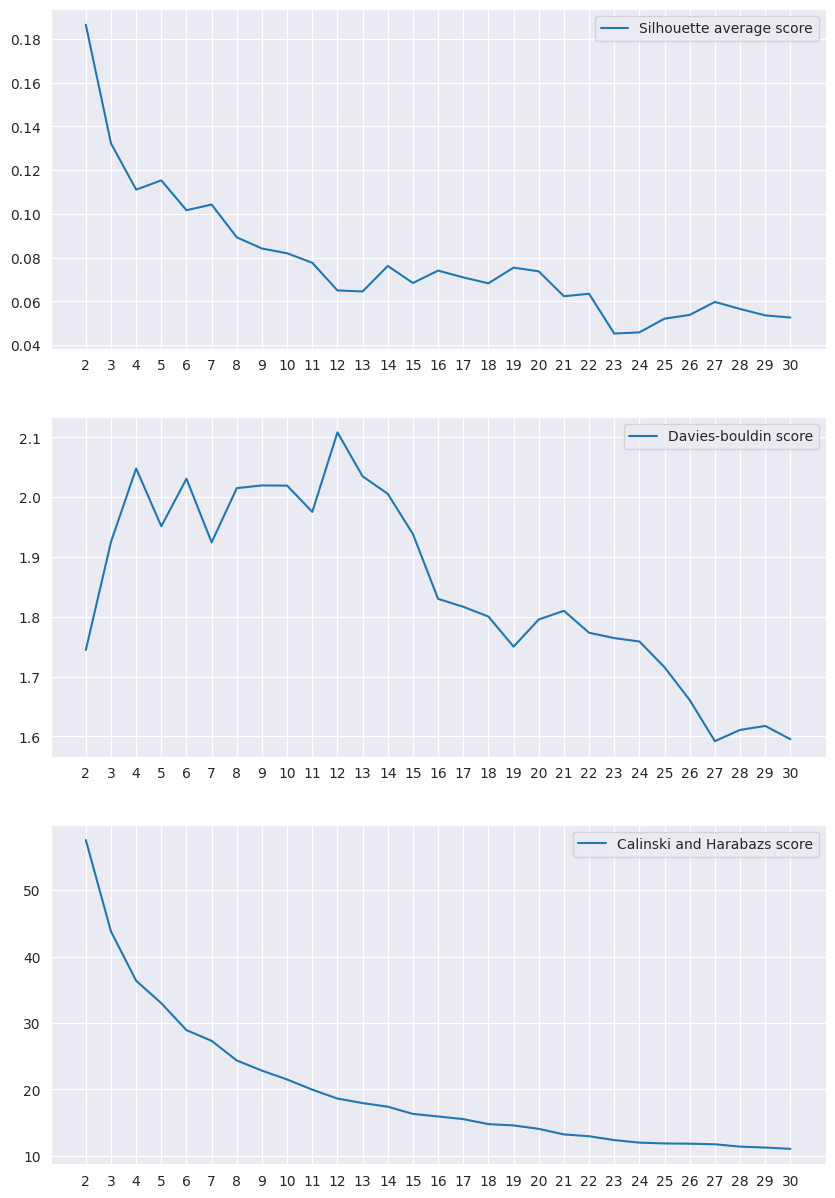

In [10]:
pca = PCA(n_components=2)
df_all_2d = pca.fit_transform(df_all)
print(pca.explained_variance_ratio_)

N_clusters_max = 30

n_clus = []
sa_scores = []
db_scores = []
ch_scores = []

labels = []

# fig, axs = plt.subplots(20, 1, figsize=(8, 20*8))
for n_clusters in np.arange(2, N_clusters_max + 1):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_all)
    labels.append(cluster_labels)
    
    sa_score = silhouette_score(df_all, cluster_labels)
    db_score = davies_bouldin_score(df_all, cluster_labels)
    ch_score = calinski_harabasz_score(df_all, cluster_labels)
    
    n_clus.append(n_clusters)
    sa_scores.append(sa_score)
    db_scores.append(db_score)
    ch_scores.append(ch_score)
    
    # axs[n_clusters - 2].scatter(df_all_2d[:,0], df_all_2d[:,1], c=cluster_labels)

fig, axs = plt.subplots(3, 1, figsize=(N_clusters_max // 3, 3 * 5))
axs[0].plot(n_clus, sa_scores, label='Silhouette average score')
axs[1].plot(n_clus, db_scores, label='Davies-bouldin score')
axs[2].plot(n_clus, ch_scores, label='Calinski and Harabazs score')

for i in range(3):
    axs[i].legend()
    axs[i].set_xticks(np.arange(2, N_clusters_max + 1))
# 
# print(sa_scores)
# print(db_scores)
# print(ch_scores)

<Figure size 1600x1600 with 0 Axes>

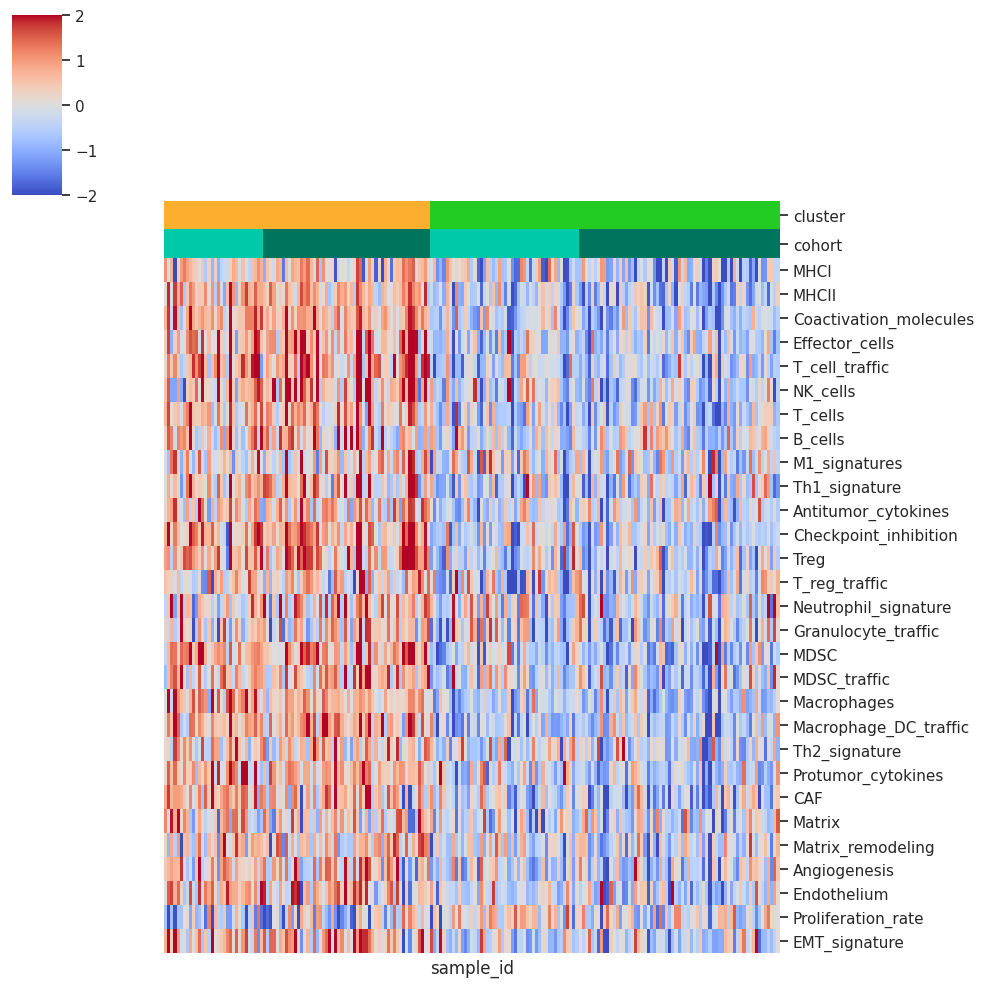

<Figure size 1600x1600 with 0 Axes>

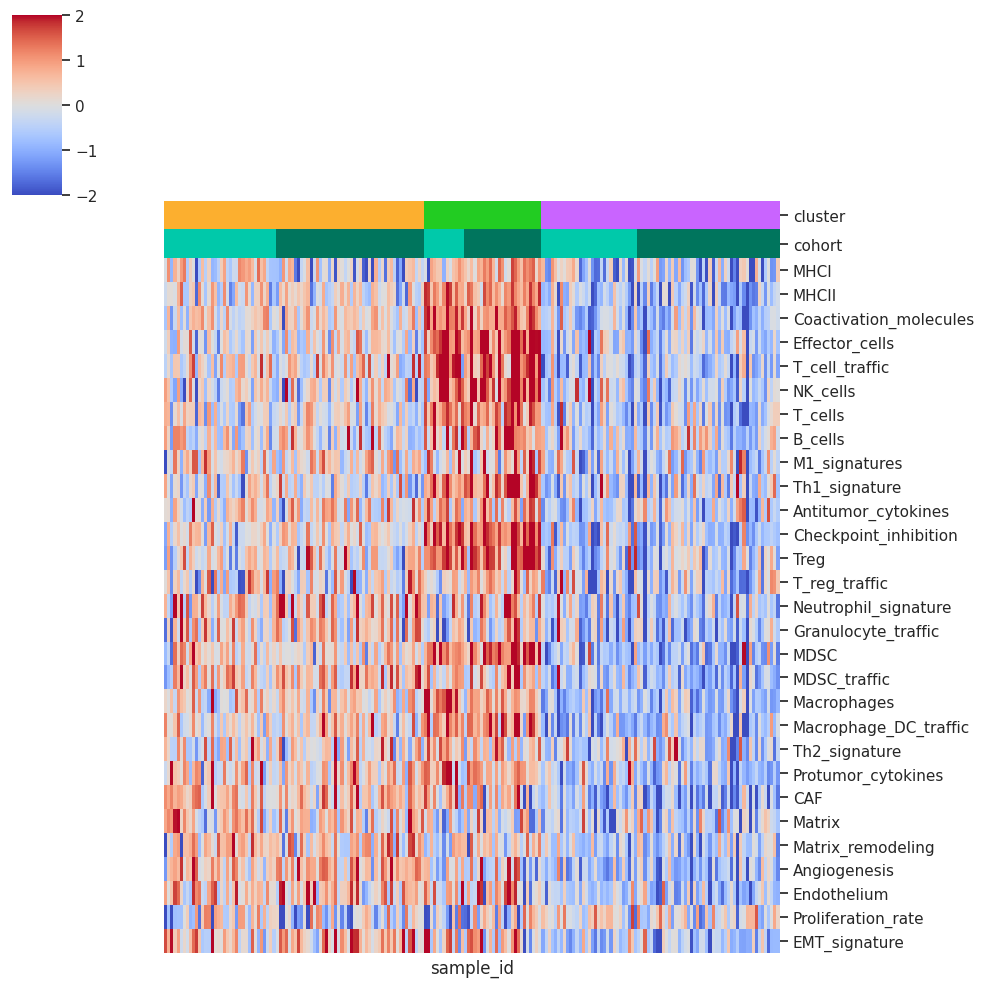

<Figure size 1600x1600 with 0 Axes>

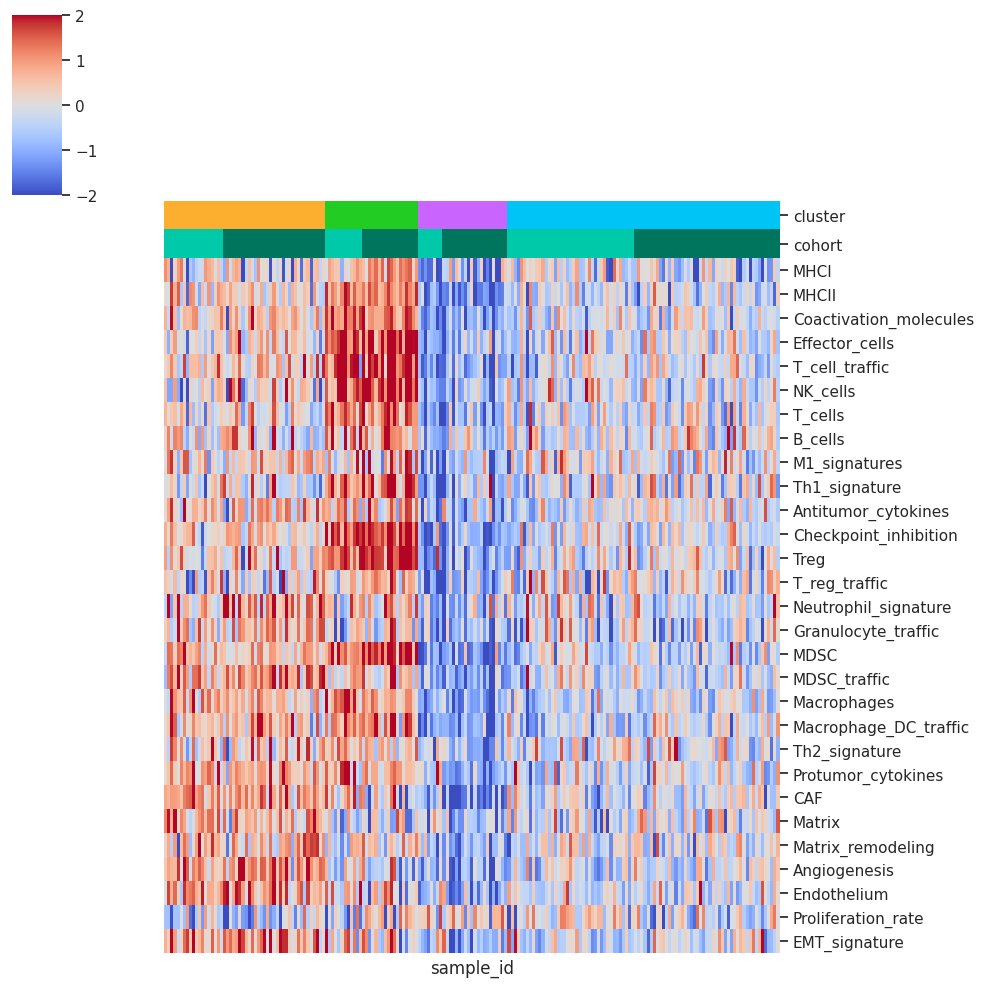

In [23]:
import matplotlib 

# Define cluster colors
CLUSTER_COLOR = {
    0: "#FCAF2F",
    1: "#22cc22",
    2: "#C964FF",
    3: "#00C4F6"
}

def label_to_color(label):
    if label in [0, 1, 2, 3]:
        return CLUSTER_COLOR[label]
    elif label == -1:
        return '#00755d'
    elif label == -2:
        return '#00c9aa'
    else:
        print('Label', label, type(label))
        raise Exception('invalid label')

def get_cohort_id(s):
    if s.startswith('GSM'):
        return -1
    else:
        return -2

def plot_heatmap(clbs):
    cohort_ids = pd.Series([get_cohort_id(e) for e in df_all.index], dtype=int, index=df_all.index) 
    
    sorted_labels_idx = np.lexsort((cohort_ids, clbs))
    sorted_labels = pd.Series(clbs, dtype=int, name='labels', index=df_all.index).iloc[sorted_labels_idx]
    sorted_df_all = df_all.loc[sorted_labels.index]
    sorted_cohort_ids = cohort_ids[sorted_labels.index]
    
    plt.figure(figsize=(16, 16))
    sns.set(style='white', rc={'figure.figsize': (20, 20)}, font_scale=1)
    
    cohort_colors = pd.DataFrame({'cluster': sorted_labels, 'cohort': sorted_cohort_ids}).map(label_to_color)
    
    g = sns.clustermap(sorted_df_all.T, 
                        vmin=-2.0, vmax=2.0,
                        cmap=matplotlib.cm.coolwarm,
                        col_colors=cohort_colors,
                        col_cluster=False,
                        row_cluster=False,
                        xticklabels=False)
    
    
    plt.show()

plot_heatmap(labels[0])
plot_heatmap(labels[1])
plot_heatmap(labels[2])

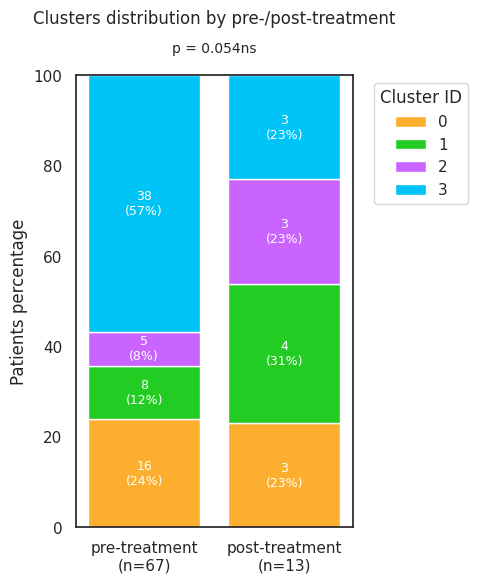

<Figure size 2000x2000 with 0 Axes>

In [14]:
df_cluster = df_all.copy()
df_cluster['cluster'] = labels[2]
df_cluster = df_cluster[['cluster']]
df_cluster = df_cluster.merge(ann_1, left_index=True, right_index=True, how='inner')[['cluster', 'time point']]


from scipy.stats import chi2_contingency

def analyze_distribution(df, group_col='time point', analyze_col='cluster'):
    """
    Analyzes distribution between time points with statistical testing
    
    Returns:
        tuple: (counts_df, percentages_df, stats_dict)
    """
    # Ensure correct ordering
    df[group_col] = pd.Categorical(
        df[group_col],
        categories=['pre-treatment', 'post-treatment'],
        ordered=True
    )

    # Generate counts table
    counts = (
        df.groupby([group_col, analyze_col], observed=True)
        .size()
        .unstack(fill_value=0)
    )
    
    # Calculate percentages
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    
    # Statistical testing
    chi2, pval, dof, expected = chi2_contingency(counts)
    n = counts.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(counts.shape) - 1)))
    
    # Prepare results
    stats = {
        'chi2': chi2,
        'p_value': pval,
        'degrees_of_freedom': dof,
        'cramers_v': cramers_v,
        'test_used': 'chi-square',
        'significance': ('*' if pval < 0.05 else 'ns') + 
                       ('*' if pval < 0.01 else '') + 
                       ('*' if pval < 0.001 else '')
    }
    
    # Add Fisher's exact test if needed
    if counts.size == 4 and (counts < 5).any().any():
        from scipy.stats import fisher_exact
        _, pval_fisher = fisher_exact(counts)
        stats.update({
            'fisher_p_value': pval_fisher,
            'test_used': "Fisher's exact"
        })
    
    return counts, percentages.round(1), stats



counts_df, percentages_df, stats = analyze_distribution(df_cluster)

percentages_df.index = [f'pre-treatment\n(n={len(ann_1[ann_1['time point'] == 'pre-treatment'])})',
                 f'post-treatment\n(n={len(ann_1[ann_1['time point'] == 'post-treatment'])})',]

# Plot
fig, ax = plt.subplots(figsize=(5, 6))
bottom = pd.Series([0] * len(percentages_df), index=percentages_df.index)

for subtype in percentages_df.columns:
    vals = percentages_df[subtype]
    bar = ax.bar(percentages_df.index, vals, bottom=bottom, label=subtype, color=CLUSTER_COLOR.get(subtype, '#cccccc'))

    for i, (val, btm) in enumerate(zip(vals, bottom)):
        if val > 0:
            count_val = counts_df[subtype].iloc[i]
            ax.text(i, btm + val / 2, f"{count_val}\n({val:.0f}%)", 
                   ha='center', va='center', fontsize=9, color='white')
    bottom += vals

# Add statistical annotation
pval_text = f"p = {stats['p_value']:.3f}{stats['significance']}"
ax.text(0.5, 1.05, pval_text, 
        transform=ax.transAxes, 
        ha='center', 
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
        fontsize=10)

ax.set_ylabel("Patients percentage")
ax.set_title("Clusters distribution by pre-/post-treatment\n", y=1.05)  # Adjusted title position
ax.set_ylim(0, 100)
ax.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
ax.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1))
plt.tight_layout()

In [15]:
# Prepare data for OS analysis
km_df = ann_2[['CMS_predicted', 'OS', 'OS_FLAG']].dropna()

# Rename and convert OS from days to months
km_df = km_df.rename(columns={
    'CMS_predicted': 'CMS',
    'OS': 'survival_time',
    'OS_FLAG': 'event'
})
km_df['survival_time'] = km_df['survival_time'] / 30.44

df_cluster = df_all.copy()
df_cluster['cluster'] = labels[2]
df_cluster = df_cluster[['cluster']]

km_df_with_cluster = df_cluster.merge(km_df, left_index=True, right_index=True, how='inner')
km_df_with_cluster

,cluster,CMS,survival_time,event
GSM5889737,3,CMS2,45.956861,0.0
GSM5889743,0,CMS4,21.927988,1.0
GSM5889750,3,CMS2,33.351551,1.0
GSM5889757,3,CMS4,34.008077,1.0
GSM5889760,2,Unc,0.984790,1.0
...,...,...,...,...
GSM5890186,0,CMS1,11.719000,1.0
GSM5890205,0,CMS3,12.670963,1.0
GSM5890210,1,CMS1,4.497207,1.0
GSM5890228,0,CMS2,64.076995,1.0


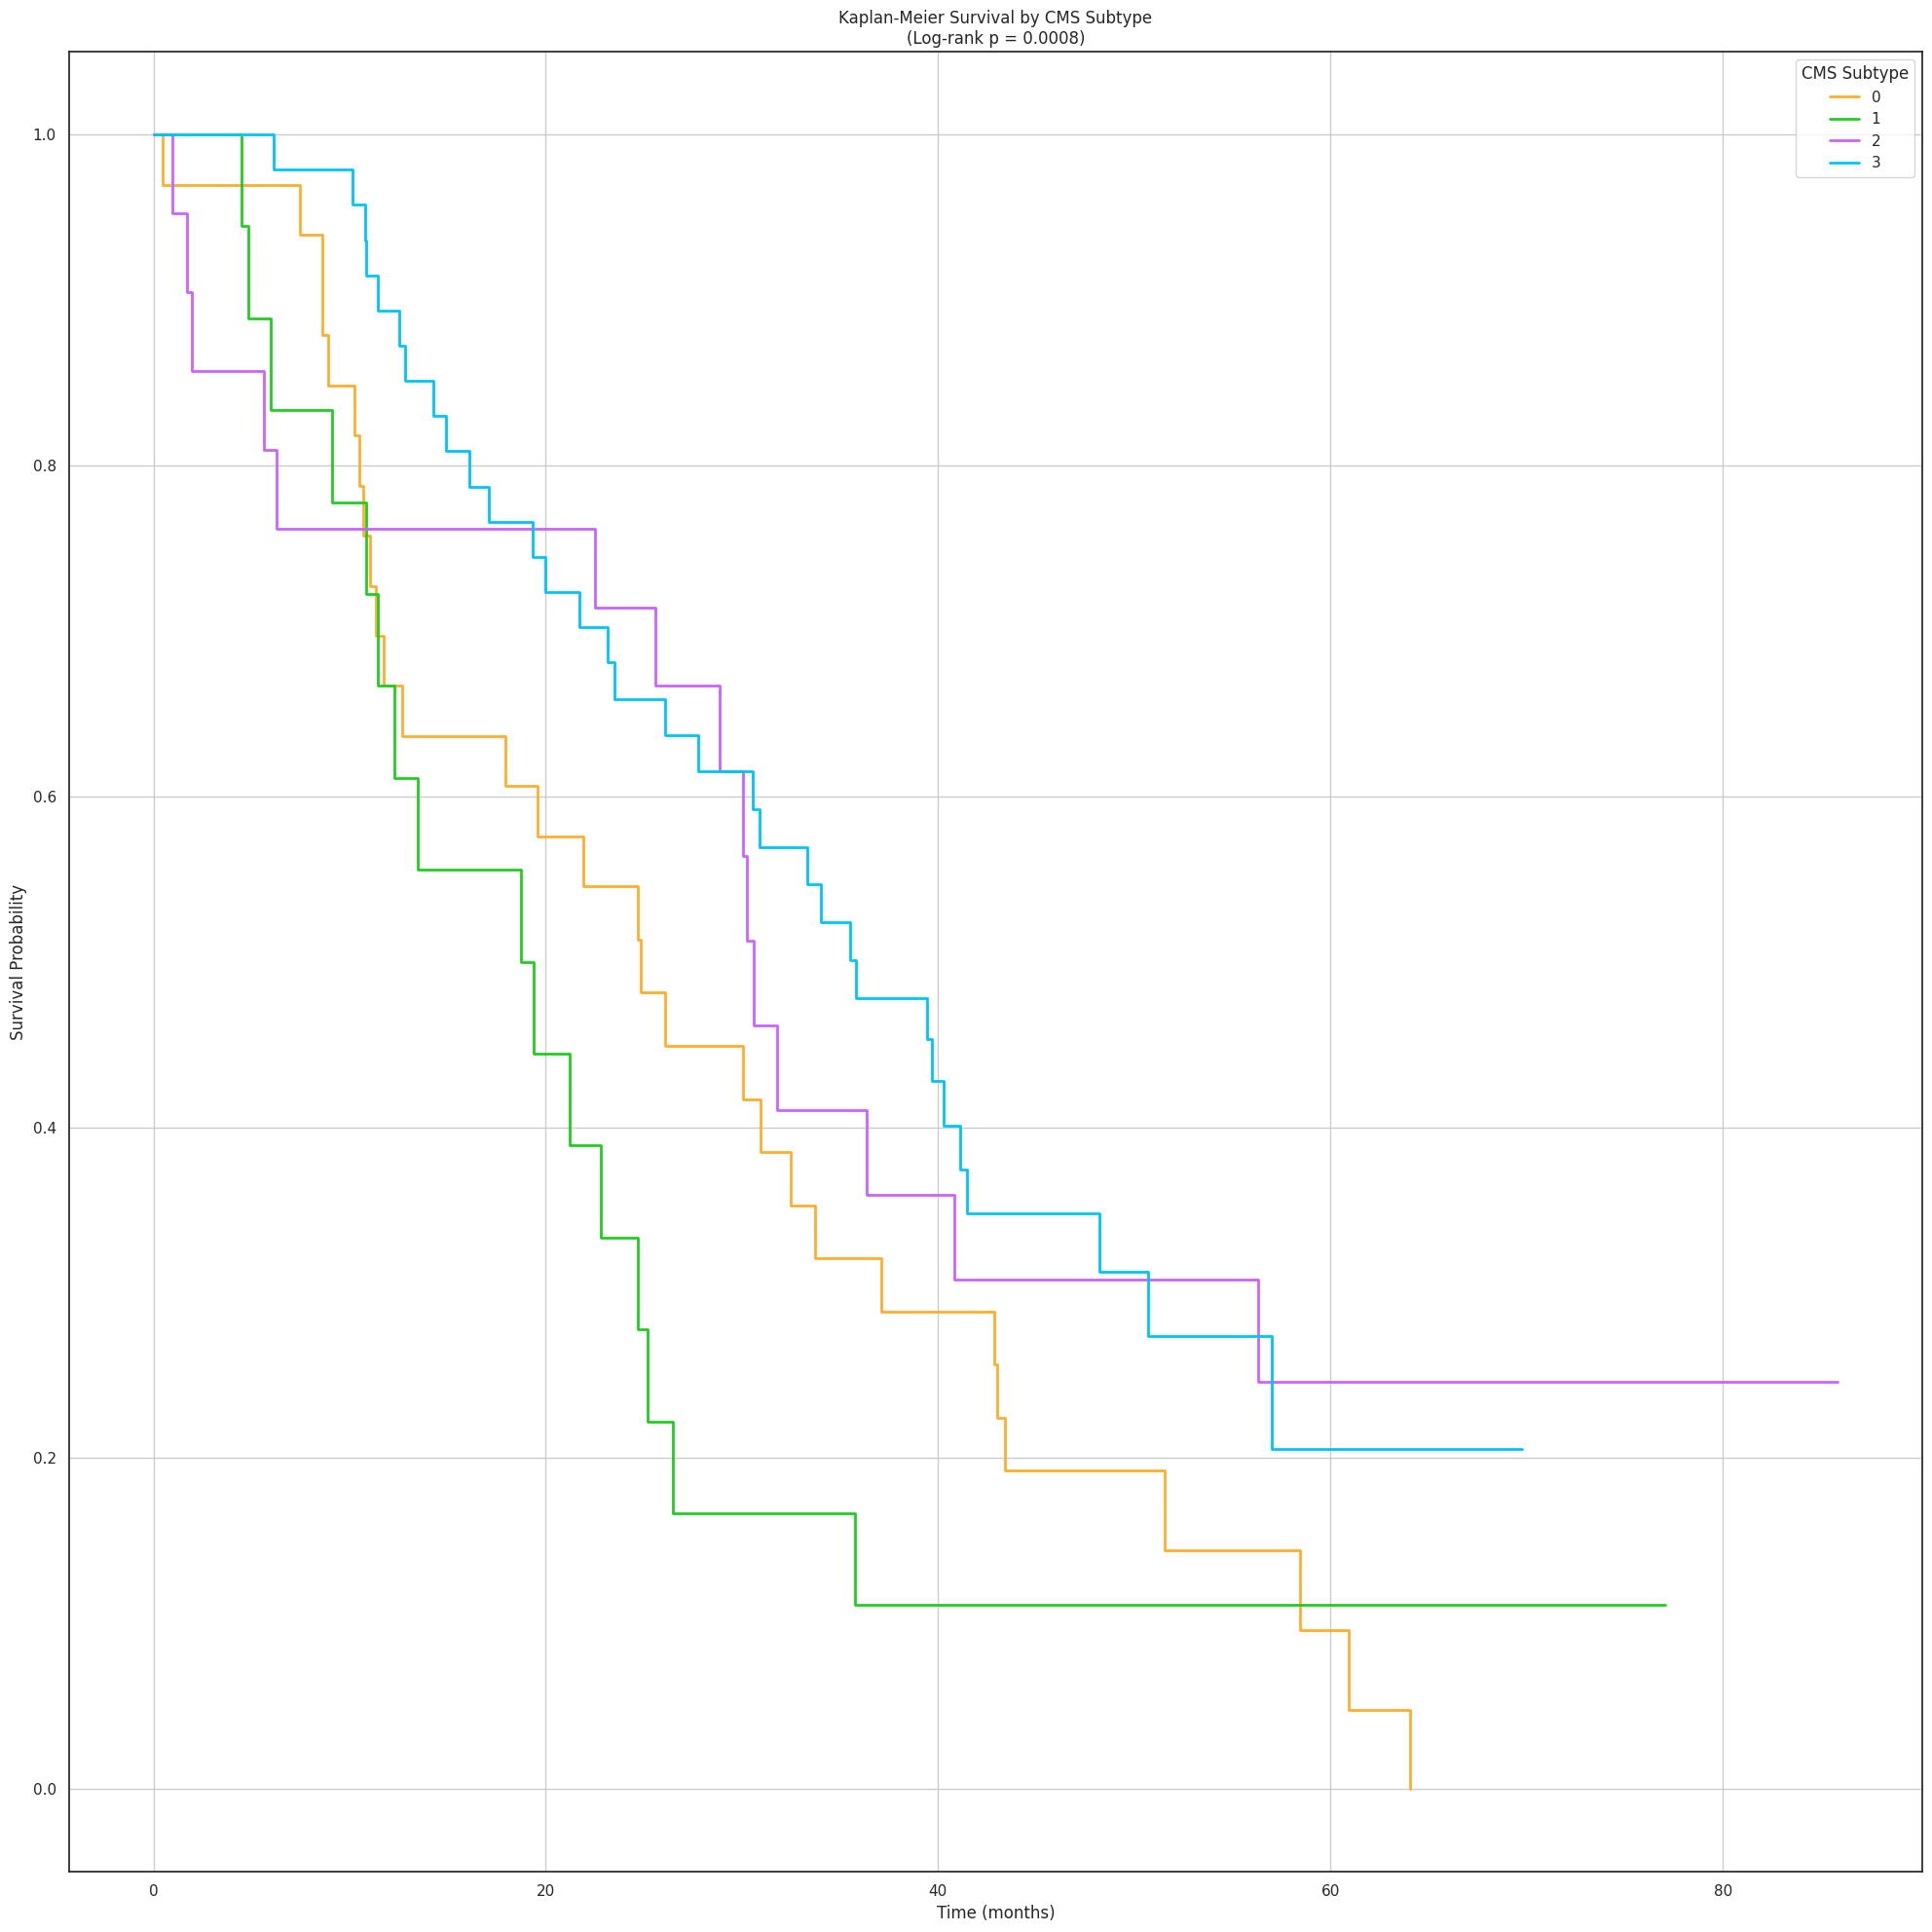

In [16]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

kmf = KaplanMeierFitter()

median_survivals = []

for cluster in [0, 1, 2, 3]:
    mask = km_df_with_cluster['cluster'] == cluster
    kmf.fit(
        durations=km_df_with_cluster.loc[mask, 'survival_time'],
        event_observed=km_df_with_cluster.loc[mask, 'event'],
        label=cluster
    )
    kmf.plot_survival_function(ci_show=False, linewidth=2, color=CLUSTER_COLOR[cluster])
    
    median_ = kmf.median_survival_time_

    # lifelines stores CI for survival curve, not directly for the median,
    # but we can approximate it by inverting the survival function.
    try:
        ci_low = kmf.confidence_interval_survival_function_.iloc[:, 1]  # upper bound
        ci_high = kmf.confidence_interval_survival_function_.iloc[:, 0]  # lower bound

        # Find where CI curves cross 0.5
        lower_ci_time = ci_low[ci_low <= 0.5].index.min()
        upper_ci_time = ci_high[ci_high <= 0.5].index.min()
    except Exception:
        lower_ci_time, upper_ci_time = np.nan, np.nan

    median_survivals.append({
        'Cluster': cluster,
        'Median Survival (months)': median_,
        '95% CI Lower (approx)': lower_ci_time,
        '95% CI Upper (approx)': upper_ci_time
    })


# --- 4. Log-rank test ---
results = multivariate_logrank_test(
    km_df['survival_time'],
    km_df['CMS'],
    event_observed=km_df['event']
)
p_value = results.p_value

# --- 5. Plot formatting ---
plt.title(f"Kaplan-Meier Survival by CMS Subtype\n(Log-rank p = {p_value:.4f})")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend(title='CMS Subtype')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_24184/3522348382.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df_cluster, x='cluster', y='EMT_signature', palette={str(x): CLUSTER_COLOR[x] for x in CLUSTER_COLOR})


<Axes: xlabel='cluster', ylabel='EMT_signature'>

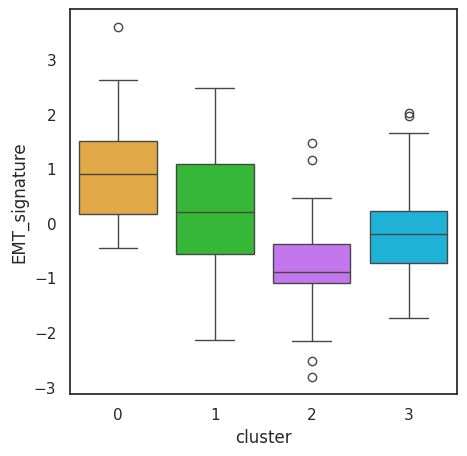

In [22]:
df_cluster = df_all.copy()
df_cluster['cluster'] = labels[2]

sns.set(style="white", rc={'figure.figsize': (5, 5)})
sns.boxplot(df_cluster, x='cluster', y='EMT_signature', palette={str(x): CLUSTER_COLOR[x] for x in CLUSTER_COLOR})

(119, 20092)


/tmp/ipykernel_24184/3592011025.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df_cluster_MET, x='cluster', y='MET', palette={str(x): CLUSTER_COLOR[x] for x in CLUSTER_COLOR})


<Axes: xlabel='cluster', ylabel='MET'>

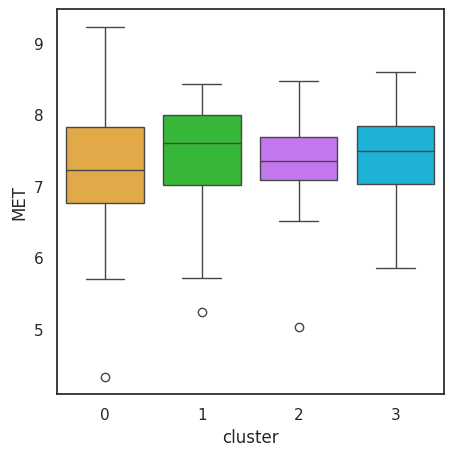

In [26]:
df_cluster_MET = df_cluster.merge(log_tpm_2, left_index=True, right_index=True, how='inner')
print(df_cluster_MET.shape)

sns.set(style="white", rc={'figure.figsize': (5, 5)})
sns.boxplot(df_cluster_MET, x='cluster', y='MET', palette={str(x): CLUSTER_COLOR[x] for x in CLUSTER_COLOR})